# Cinepolis EDA: Do emails influence visits?

**Scope:**
- Explore five datasets: Transactions, Pricebook, Customers, Emails, Releases.
- Assess patterns linking email activity and cinema visits (tickets/transactions).
- Important: We lack a clean control group of buyers who never received emails.


**Owner/date:** @roman, 2025-08-11

---
# 0. Setup and Configuration

This notebook reproduces and clarifies the exploratory analysis around email campaigns and cinema visits.

**Key limitations:**
- We do not have a robust counterfactual group: buyers who never received any emails are scarce or undefined in scope.
- Any association we show here is not causal. We will propose next steps for causal evaluation.

**Libraries and configuration:**
- MAX_DATE caps training data for Prophet to avoid illness of the incomplete segments of information provided.


In [1]:
# Setup: imports and display options
# - We import libraries used throughout the analysis
# - Plots render inline in VS Code outputs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re
import uuid
import datetime as dt

# Forecasting / decomposition (descriptive use only)
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import holidays

# Statistical utilities
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier, Pool
import shap

# Show all columns when printing DataFrames
pd.set_option('display.max_columns', None)

# Plot style
sns.set(style="whitegrid", context="talk")

# Reproducibility
np.random.seed(42)

# Cap date used for Prophet training to avoid looking too far forward
MAX_DATE = dt.datetime(2024, 7, 15)
MAX_DATE

datetime.datetime(2024, 7, 15, 0, 0)

---
# 1. Load Source Data

We load five CSV datasets stored under ../data. We keep default dtype inference but remain aware it may parse IDs as numeric if not quoted. Releases file uses a pipe `|` separator.

In [ ]:
# Read source
df_transactions = pd.read_csv("../data/Transactions.csv", header=0)
df_pricebook   = pd.read_csv("../data/Pricebook.csv", header=0)
df_customers   = pd.read_csv("../data/Customers.csv", header=0)
df_emails      = pd.read_csv("../data/Emails.csv", header=0)
df_releases    = pd.read_csv("../data/Releases.csv", header=0, sep="|")

# Quick size checks
print("Rows - transactions:", len(df_transactions))
print("Rows - pricebook:",   len(df_pricebook))
print("Rows - customers:",   len(df_customers))
print("Rows - emails:",      len(df_emails))
print("Rows - releases:",    len(df_releases))

Rows - transactions: 329580
Rows - pricebook: 103
Rows - customers: 5718369
Rows - emails: 1864512
Rows - releases: 412


---
# 2. EDA

This section groups data preparation, demand analytics, customer and campaign analysis, and attribution diagnostics.

Subsections
- 2.1 Data Preparation & Quality
- 2.2 Demand, Sales & Seasonality
- 2.3 Customer Segmentation & Email Exposure
- 2.4 Conversion & Attribution Analysis
- 2.5 Key Findings & Next Steps

---
## 2.1 Data Preparation & Quality

### 2.1.1 Transactions: Deduplication and Cleaning

We construct a deterministic transaction key, fix ticket counts, drop invalid rows, and aggregate duplicates to a single record per transaction.

In [ ]:
# Create a stable transaction_id using id
_df = df_transactions.copy()
_df['transaction_id'] = _df.apply(
    lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{x['CARD_MEMBERSHIPID']}_{x['FECHA_TRANSACCION']}_{x['FECHA_FUNCION']}")),
    axis=1
)

# Ensure ticket counts are non-negative and remove zero-ticket rows (invalid sales)
_df['BOLETOS'] = _df['BOLETOS'].abs()
_df = _df.query('BOLETOS > 0').reset_index(drop=True)

# Aggregate duplicates by transaction_id
_df = (
    _df
    .groupby('transaction_id', as_index=False)
    .agg({
        'ID_CINE': 'first',
        'FECHA_TRANSACCION': 'first',
        'FECHA_FUNCION': 'first',
        'CARD_MEMBERSHIPID': 'first',
        'ID_MARCA': 'first',
        'TX_PELICULA_UNICA': 'first',
        'BOLETOS': 'sum',
        'IMPORTE_TAQUILLA': 'sum'
    })
    .assign(
        FECHA_TRANSACCION=lambda x: pd.to_datetime(x['FECHA_TRANSACCION'], format='%Y-%m-%d', errors='coerce'),
        FECHA_FUNCION=lambda x: pd.to_datetime(x['FECHA_FUNCION'], format='%Y-%m-%d', errors='coerce')
    )
    .sort_values(by='FECHA_TRANSACCION', ascending=True, ignore_index=True)
)

# Replace original
df_transactions = _df

# Quick structure check
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321600 entries, 0 to 321599
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     321600 non-null  object        
 1   ID_CINE            321600 non-null  int64         
 2   FECHA_TRANSACCION  321600 non-null  datetime64[ns]
 3   FECHA_FUNCION      321600 non-null  datetime64[ns]
 4   CARD_MEMBERSHIPID  321600 non-null  object        
 5   ID_MARCA           321600 non-null  int64         
 6   TX_PELICULA_UNICA  321600 non-null  object        
 7   BOLETOS            321600 non-null  int64         
 8   IMPORTE_TAQUILLA   321600 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(3), object(3)
memory usage: 22.1+ MB


### Transactions cleaning: insights

- From 329580 raw rows, we reduce to 321600, that is a 2.5% reduction

---
### 2.1.2 Transactions: Aggregates and Descriptives

We summarize ticket volume and per-transaction behavior to set baselines.

In [4]:
# Key KPIs for tickets per transaction
total_trx = df_transactions.shape[0]
total_tickets = df_transactions['BOLETOS'].sum()
avg_tickets_per_trx = df_transactions['BOLETOS'].mean()
share_gt1 = df_transactions['BOLETOS'].gt(1).mean()  # multi-ticket share
p99_tickets = df_transactions['BOLETOS'].quantile(0.99)  # heavy tail indicator

print(f"Total transactions: {total_trx}")
print(f"Avg tickets/transaction: {avg_tickets_per_trx:.2f}")
print(f"Share with >1 ticket: {share_gt1:.4f}")
print(f"99th percentile of tickets/transaction: {p99_tickets:.2f}")

Total transactions: 321600
Avg tickets/transaction: 2.08
Share with >1 ticket: 0.7474
99th percentile of tickets/transaction: 6.00


### Transactions KPIs: insights
- On average, each transaction involves 2 tickets, exactly 3 of 4 buyers purchase more than 1 ticket.
- The majority of transaction are less than 6 tickets

---
### 2.1.3 Pricebook: Overview

We review key pricing fields used later for child-ticket heuristics.

In [5]:
# Summary stats to check ranges and missingness
df_pricebook['PRECIO_POL_R'].describe()

count    103.000000
mean      80.291262
std       37.997583
min       40.000000
25%       55.000000
50%       72.000000
75%       82.500000
max      195.000000
Name: PRECIO_POL_R, dtype: float64

---
### 2.1.4 Customers: Overview and Duplicates

We sanity-check size and uniqueness, anticipating a 1:1 link to email subscriber keys.

In [6]:
# Customers quick look
print(df_customers.shape)
df_customers.head()

# Distribution / sanity checks
df_customers.describe()

# Duplicate check on CARD_MEMBERSHIPID (expected unique per customer)
df_customers[df_customers.duplicated(subset=['CARD_MEMBERSHIPID'], keep=False)]\
    .sort_values(by='CARD_MEMBERSHIPID')

(5718369, 2)


,CARD_MEMBERSHIPID,SubscriberKey


### Customers: insights
- CARD_MEMBERSHIPID appears to be the unique customer key; duplicates would signal data issues.
- This key is also used to link to emails and transactions downstream; linkage quality matters for any attribution.


---
### 2.1.5 Emails: Merge with Customers and Time Features

We restrict to known customers (inner join) and derive date and hour to analyze send cadence.

(1864512, 3)
year
2019    107603
2020    117808
2021    169210
2022    304362
2023    678740
2024    486789
dtype: int64
(338259, 6)
% of emails matching customers: 5.92%


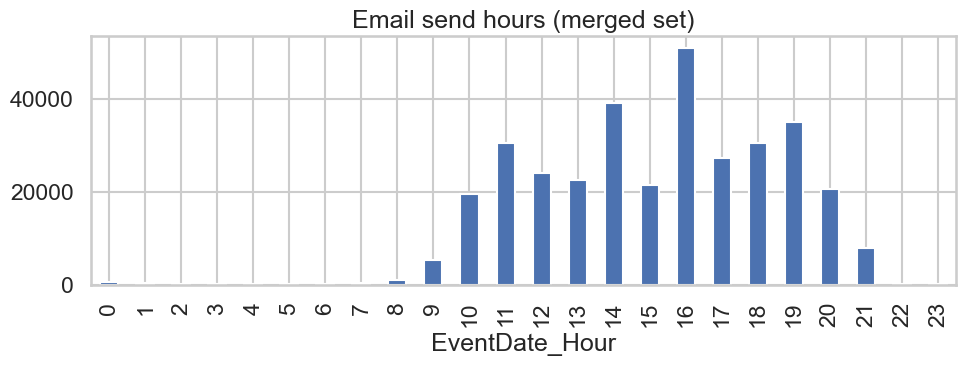

In [ ]:
# Emails: raw overview
print(df_emails.shape)

# Parse EventDate
_emails = df_emails.copy()
_emails['EventDate_TS'] = pd.to_datetime(_emails['EventDate'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
_emails['year'] = _emails['EventDate_TS'].dt.year
print(_emails.groupby('year').size())

# Subset emails only since 2024-jan up to 2024-07-15 (heuristic for analysis period)
_emails = _emails.query('EventDate_TS >= "2024-01-01" and EventDate_TS < "2024-07-15"').reset_index(drop=True)

# Merge with customers (semi-join): keep only emails tied to known customers
_emails = (
    _emails
    .merge(df_customers, how='inner', left_on='SubscriberKeyH', right_on='SubscriberKey')
    .drop(columns=['SubscriberKeyH', 'SubscriberKey'])
)

# Derive date-only and hour-of-day fields for cadence analysis
_emails['EventDate'] = _emails['EventDate_TS'].dt.date
_emails['EventDate'] = pd.to_datetime(_emails['EventDate'], format='%Y-%m-%d', errors='coerce')
_emails['EventDate_Hour'] = _emails['EventDate_TS'].dt.hour

# Replace original merged emails
df_emails = _emails.reset_index(drop=True)

# Quick coverage check post-merge
print(df_emails.shape)
print(f"% of emails matching customers: {df_emails.shape[0] / max(len(df_customers), 1) * 100:.2f}%")

df_emails['EventDate_Hour'].value_counts().sort_index().plot(kind='bar', figsize=(10, 4))
plt.title('Email send hours (merged set)')
plt.tight_layout()
plt.show()


### Emails: insights
- Email volume varies, sending hours cluster within business hours.
- Only a small share ~6% of raw emails link to customers in scope, on 2024, limiting representativeness.
- Timezone assumptions may slightly shift same-day matching; we proceed with stated parsing for consistency, however it stated as been in UTC.

---
### 2.1.6 Releases: Cleaning and Filtering

We focus on titles with non-zero sales and standardize dates to align with transaction windows.

In [8]:
# Standardize release date and remove zero-sales titles (focus on active titles)
df_releases['ESTRENO'] = pd.to_datetime(df_releases['ESTRENO'], format='%Y-%m-%d', errors='coerce')
print('Zero-sales titles:', df_releases.query('VENTAS == 0').shape[0])
df_releases = df_releases.query('VENTAS > 0').reset_index(drop=True)

# Post-filtering summary
df_releases.describe(include='all')

Zero-sales titles: 1


,TX_PELICULA_UNICA,ESTRENO,VENTAS
count,411,411,4.110000e+02
unique,411,NaN,NaN
top,48HFP X EDICIÓN: GRUPO A,NaN,NaN
freq,1,NaN,NaN
mean,NaN,2024-04-14 16:10:30.656934400,9.479517e+04
min,NaN,2024-01-01 00:00:00,1.000000e+00
25%,NaN,2024-02-18 00:00:00,2.400000e+01
50%,NaN,2024-04-25 00:00:00,9.210000e+02
75%,NaN,2024-06-11 00:00:00,2.669000e+04
max,NaN,2024-08-21 00:00:00,6.156314e+06


### Releases: insights
- We retain only titles with reported sales, aligning with observed transactions.
- The cleaned set defines the pipeline for on-air and blockbuster analyses.

---
## 2.2 Demand, Sales & Seasonality

### 2.2.1 Holidays: Mexico Calendar

We prepare a holiday frame for the transactions window to annotate charts and use in Prophet.

In [9]:
# Build Mexican holidays across the transactions period
start_date = df_transactions['FECHA_TRANSACCION'].min()
end_date   = df_transactions['FECHA_TRANSACCION'].max()
_date_range = pd.date_range(start=start_date, end=end_date)
mx_holidays = holidays.MX(years=_date_range.year.unique())

# Frame for holidays compatible with Prophet
holiday_dates = [d for d in _date_range if d in mx_holidays]
holiday_names = [mx_holidays[d] for d in holiday_dates]
df_mx_holidays = pd.DataFrame({'date': holiday_dates, 'holiday': holiday_names})
df_mx_holidays['lower_window'] = 0
df_mx_holidays['upper_window'] = 0

df_mx_holidays.head()

,date,holiday,lower_window,upper_window
0,2024-01-01,Año Nuevo,0,0
1,2024-02-05,Día de la Constitución,0,0
2,2024-03-18,Natalicio de Benito Juárez,0,0
3,2024-05-01,Día del Trabajo,0,0


---
### 2.2.2 Sales: Daily Time Series with Holidays

We build a daily series of tickets and transactions (by show date) and annotate weekends and holidays.

(237, 6)
Range: 2024-01-01 00:00:00 to 2024-08-24 00:00:00


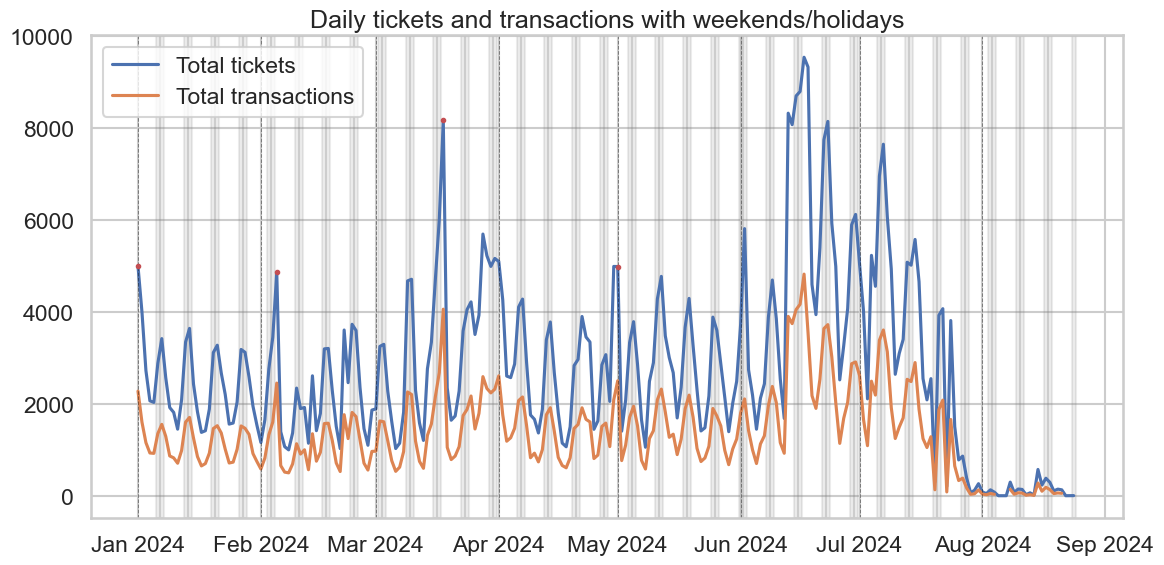

In [10]:
# Aggregate daily by FECHA_FUNCION (show date)
ts_tickets = (
    df_transactions
    .groupby('FECHA_FUNCION', as_index=False)
    .agg({'BOLETOS': ['sum', 'count']})
    .rename(columns={'FECHA_FUNCION': 'date'})
    .reset_index(drop=True)
)
# Flatten multiindex columns
ts_tickets.columns = ['date', 'total_tickets', 'total_transactions']

# Reindex to a complete date range; fill missing ticket days with 0
full_range = pd.date_range(start=ts_tickets['date'].min(), end=ts_tickets['date'].max())
ts_tickets = ts_tickets.set_index('date').reindex(full_range).reset_index()\
    .rename(columns={'index': 'date'})
ts_tickets['total_tickets'] = ts_tickets['total_tickets'].fillna(0)

# Join holidays for plotting
ts_tickets = ts_tickets.merge(df_mx_holidays, how='left', on='date')

print(ts_tickets.shape)
print('Range:', ts_tickets['date'].min(), 'to', ts_tickets['date'].max())

# Plot: tickets and number of transactions
plt.figure(figsize=(12, 6))
plt.plot(ts_tickets['date'], ts_tickets['total_tickets'], label='Total tickets', color='C0')
plt.plot(ts_tickets['date'], ts_tickets['total_transactions'], label='Total transactions', color='C1')

# Month separators
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
for d in ts_tickets['date'][ts_tickets['date'].dt.is_month_start]:
    ax.axvline(d, color='black', linestyle='--', linewidth=0.7, alpha=0.4)

# Weekend shading
for d in ts_tickets['date']:
    if d.weekday() >= 5:  # Sat/Sun
        ax.axvspan(d - pd.Timedelta(hours=12), d + pd.Timedelta(hours=12), color='gray', alpha=0.15)

# Holiday markers
for _, row in df_mx_holidays.iterrows():
    if row['date'] >= ts_tickets['date'].min() and row['date'] <= ts_tickets['date'].max():
        plt.plot(row['date'], ts_tickets.loc[ts_tickets['date'] == row['date'], 'total_tickets'].values[0], 'ro', markersize=3)

plt.title('Daily tickets and transactions with weekends/holidays')
plt.legend()
plt.tight_layout()
plt.show()

### Sales TS: insights
- Clear weekend seasonality with elevated demand; holidays often amplify or shift peaks
- Transaction counts co-move with tickets, confirming stable average basket sizes in aggregate, it looks as a multiple of 2.0x.

### Holidays: insights
- National holidays shifts demand spikes on weekends

---
### 2.2.3 Sales: Decomposition with Prophet

We decompose the daily ticket series into trend and seasonal components using holidays and weekly/monthly seasonality.

18:07:48 - cmdstanpy - INFO - Chain [1] start processing
18:07:48 - cmdstanpy - INFO - Chain [1] done processing
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: divide by zero encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: overflow encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1418: RuntimeWarning: invalid value encountered in matmul
  comp = np.matmul(X, beta_c.transpose())
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1562: RuntimeWarning: divide by zero encountered in matmul
  Xb_a = np.matmul(seasonal_features.values,
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/prophet/forecaster.py:1562: RuntimeWarning: 

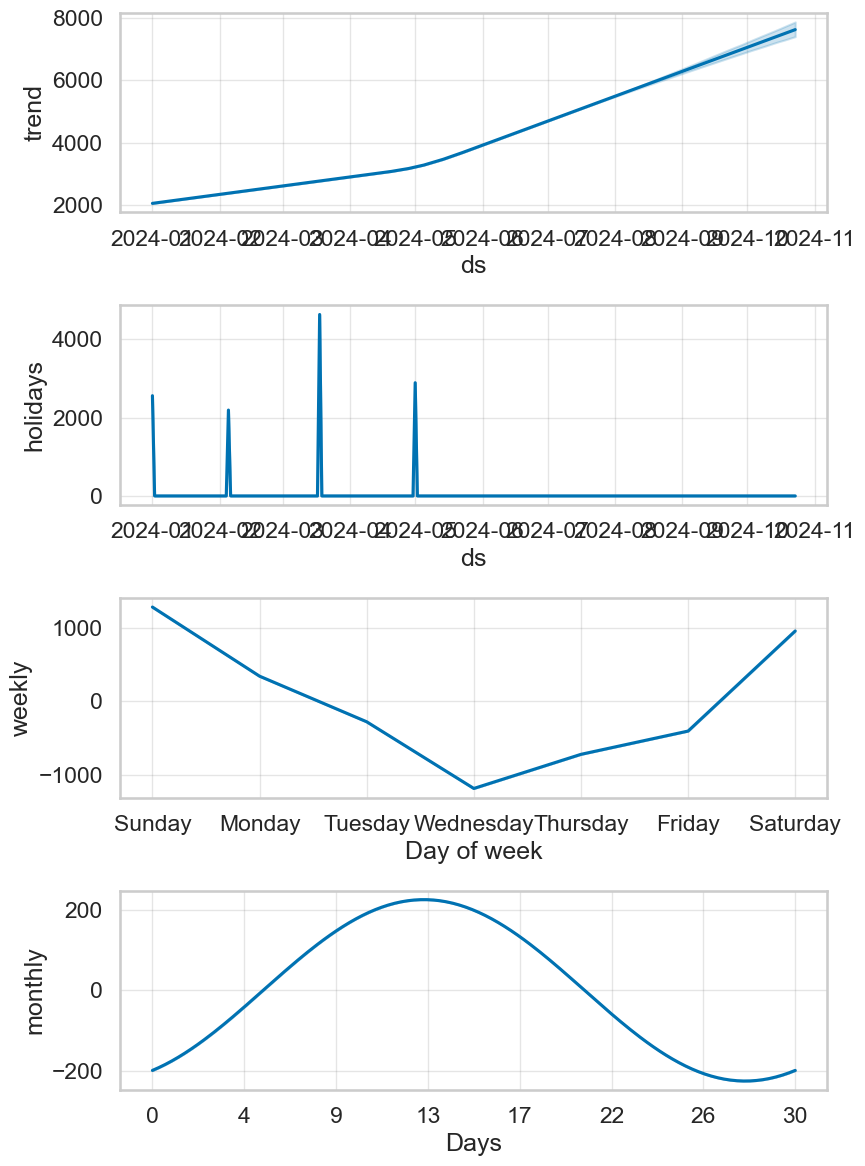

In [11]:
# Prepare Prophet-compatible frame (ds/y), cap to MAX_DATE
df_prophet = (
    ts_tickets
    .rename(columns={'date': 'ds', 'total_tickets': 'y'})
    .assign(ds=lambda x: pd.to_datetime(x['ds'], errors='coerce'),
            y=lambda x: x['y'].astype(float))
    .dropna(subset=['ds', 'y'])
    .query('ds <= @MAX_DATE')
    .drop(columns=['total_transactions', 'holiday'], errors='ignore')
)

# Configure Prophet
# - weekly_seasonality captures weekend spikes
# - yearly off due to limited horizon; monthly added via Fourier terms
# - holidays provided for national effects
m = Prophet(
    changepoint_prior_scale=0.05,
    changepoint_range=1,
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=False,
    holidays=df_mx_holidays.rename(columns={'date': 'ds'}),
    seasonality_mode='additive',
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=1)

# Fit and visualize components (descriptive)
m.fit(df_prophet)
future = m.make_future_dataframe(periods=100, freq='D')
fcst = m.predict(future)
fig = m.plot_components(fcst)

### Prophet: insights
- Trend and weekly components align with observed weekend spikes; holidays add short-lived lifts.
- Use as a descriptive lens
- It looks that weekly seasonality is strong, with holidays amplifying weekend peaks
- It look that the day 15th of each month influences demand spikes, possibly due to paydays; however is not as strong as weekly seasonality and less than holidays

---
## 2.3 Customer Segmentation & Email Exposure

### 2.3.1 Emails vs Transactions: Customer-Level Join

We summarize per-customer behavior and compare segments with and without any email exposure in our merged scope.

In [12]:
# Build customer aggregates from transactions
cust_trx = (
    df_transactions
    .groupby('CARD_MEMBERSHIPID', as_index=False)
    .agg(
        total_tickets=('BOLETOS', 'sum'),
        total_transactions=('transaction_id', 'nunique'),
        total_spent=('IMPORTE_TAQUILLA', 'sum')
    )
)

# Count unique campaigns emailed per customer (merged emails only)
cust_email = (
    df_emails.groupby('CARD_MEMBERSHIPID', as_index=False)
    .agg(num_emails=('SendId', 'nunique'))
)

# Left-join to keep all buyers; fill NaN for non-emailed buyers in this scope
cust_join = (
    cust_trx
    .merge(cust_email, how='left', on='CARD_MEMBERSHIPID')
    .assign(num_emails=lambda x: x['num_emails'].fillna(0).astype(int))
)

print(f"Percent of buyers with any email in-scope: {cust_join['num_emails'].gt(0).mean()*100:.2f}%")
print(f"Total buyers: {cust_join.shape[0]}")

# Compare segments (descriptive only)
seg = (
    cust_join
    .assign(email_group=lambda x: np.where(x['num_emails'].gt(0), 'With Emails', 'Without Emails'))
    .groupby('email_group')
    .agg(
        avg_tickets=('total_tickets', 'mean'),
        avg_transactions=('total_transactions', 'mean'),
        avg_spent=('total_spent', 'mean'),
        users=('CARD_MEMBERSHIPID', 'nunique')
    )
    .reset_index()
)
seg

Percent of buyers with any email in-scope: 6.05%
Total buyers: 264155


,email_group,avg_tickets,avg_transactions,avg_spent,users
0,With Emails,2.590480,1.252768,166.660380,15987
1,Without Emails,2.522509,1.215193,162.712593,248168


### Emails vs transactions: insights
- Emailed customers often differ in behavior from non-emailed, but this comparison is confounded by selection.
- We lack a clean control cohort of buyers who never received emails, so differences are not causal.
- Consider holdout tests or randomized assignments for future causal measurement.

---
### 2.3.2 Emails: Daily and Weekly Send Volume

We examine cadence by day and aggregate to week to smooth bursts.

(177, 2)
Total emails in 2024+ window: 338259


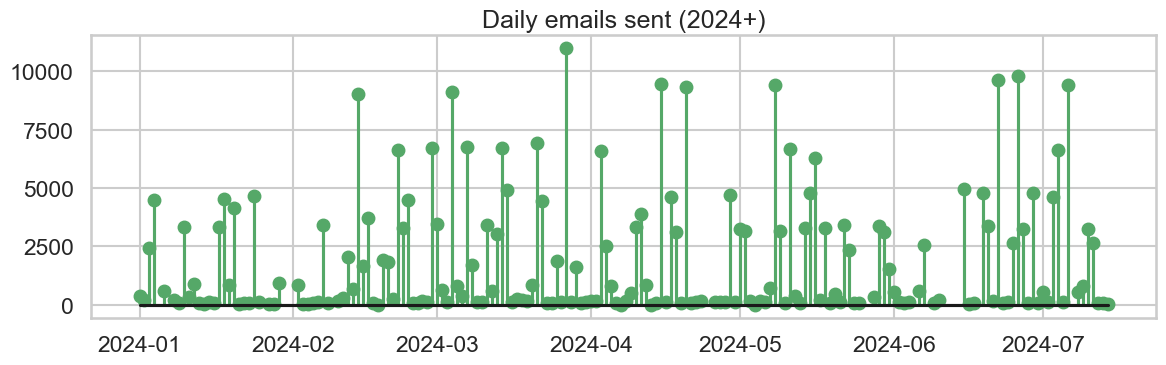

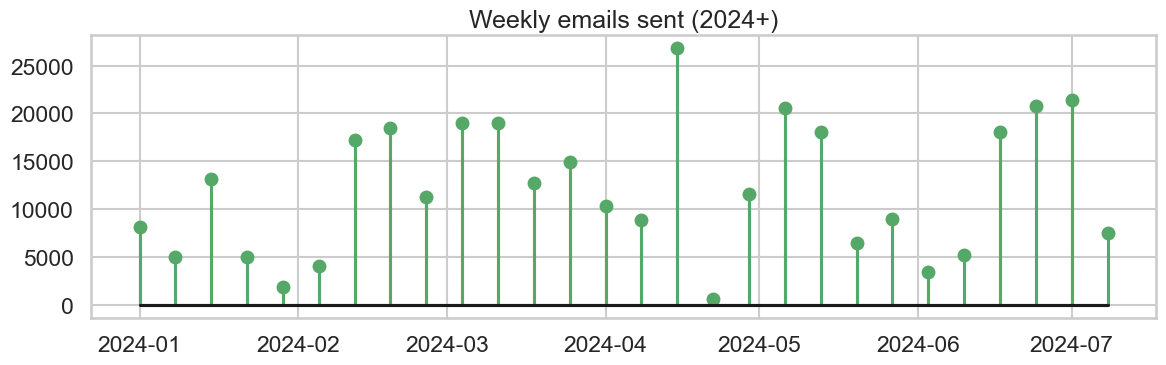

In [13]:
# Daily email sends (restrict to 2024+ for focus)
ts_emails = (
    df_emails
    .groupby('EventDate', as_index=False)
    .size()
    .rename(columns={'EventDate': 'date', 'size': 'emails_sent'})
    .assign(date=lambda x: pd.to_datetime(x['date'], errors='coerce'))
    .loc[lambda x: x['date'] >= '2024-01-01']
    .sort_values('date')
)

print(ts_emails.shape)
print('Total emails in 2024+ window:', ts_emails['emails_sent'].sum())

plt.figure(figsize=(12, 4))
(markerline, stemlines, baseline) = plt.stem(ts_emails['date'], ts_emails['emails_sent'], linefmt='g-', markerfmt='go', basefmt='k-')
plt.title('Daily emails sent (2024+)')
plt.tight_layout()

# Weekly aggregation using period to get week start
_ts = ts_emails.copy()
_ts['year_week'] = _ts['date'].dt.to_period('W').dt.start_time
ts_emails_weekly = _ts.groupby('year_week', as_index=False)['emails_sent'].sum()\
    .rename(columns={'year_week': 'date'})

plt.figure(figsize=(12, 4))
plt.stem(ts_emails_weekly['date'], ts_emails_weekly['emails_sent'], linefmt='g-', markerfmt='go', basefmt='k-')
plt.title('Weekly emails sent (2024+)')
plt.tight_layout()

### Email cadence: insights
- Sending seems random days; weekly sums doesn't show clear patterns.

---
### 2.3.3 Campaigns: Size, Duration, and Concurrency

We profile SendId-level activity to understand campaign size, duration, and overlap on the calendar.

(634, 5)
Share of emails sent on single-day campaigns: 0.8583688830156774
(177, 2)


,SendId,num_emails,num_days,date_start,date_end
562,1456992,9513,0,2024-06-22,2024-06-22
612,1457396,9335,0,2024-07-06,2024-07-06
443,1454551,9166,0,2024-04-15,2024-04-15
278,1452762,8966,0,2024-03-04,2024-03-04
497,1455384,6474,0,2024-05-08,2024-05-08
250,1452504,6474,0,2024-02-29,2024-02-29
576,1457059,5393,0,2024-06-26,2024-06-26
339,1453554,5353,0,2024-03-21,2024-03-21
476,1454869,5263,0,2024-04-20,2024-04-20
288,1452933,5260,0,2024-03-07,2024-03-07


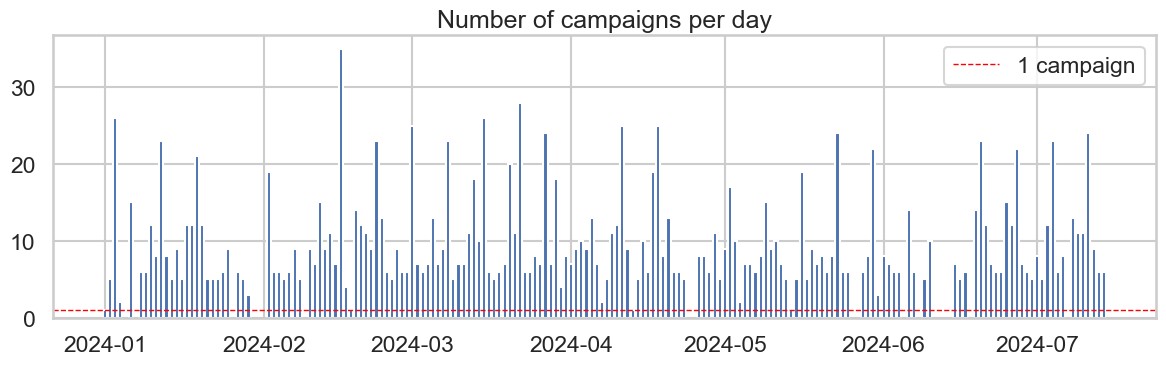

In [14]:
# Per-campaign metrics
emails_per_campaign = (
    df_emails
    .groupby('SendId', as_index=False)
    .agg(
        num_emails=('EventDate', 'count'),
        num_days = ('EventDate', lambda x: (x.max() - x.min()).days),
        date_start=('EventDate', 'min'),
        date_end=('EventDate', 'max')
    )
)

print(emails_per_campaign.shape)
print('Share of emails sent on single-day campaigns:',
      emails_per_campaign.query('num_days <= 0')['num_emails'].sum() / max(emails_per_campaign['num_emails'].sum(), 1))

# Campaign concurrency by date
campaigns_by_date = (
    df_emails.groupby('EventDate')['SendId'].nunique().reset_index(name='num_campaigns')
)
print(campaigns_by_date.shape)

plt.figure(figsize=(12, 4))
plt.bar(campaigns_by_date['EventDate'], campaigns_by_date['num_campaigns'], width=0.8)
plt.axhline(y=1, color='red', linestyle='--', linewidth=1, label='1 campaign')
plt.title('Number of campaigns per day')
plt.legend()
plt.tight_layout()

# Top campaigns by volume
emails_per_campaign.sort_values(by='num_emails', ascending=False).head(10)

### Campaigns: insights
- Many campaigns run in a single day; some dates have multiple overlapping campaigns.
- Concurrency complicates attribution for a campaign; control designs or staggered rollouts should be used to isolate impact.

---
## 2.4 Conversion & Attribution Analysis

### 2.4.1 Conversion: ±7-Day Window Analysis

Windowed match where a customer's transaction falls within -7 to +7 days of an email.

In [15]:
# Same-day conversion: strict equality on date
users_email_unique = df_emails[['CARD_MEMBERSHIPID']].drop_duplicates()
users_trx_unique   = df_transactions[['CARD_MEMBERSHIPID']].drop_duplicates()
users_overlap = users_email_unique.merge(users_trx_unique, how='inner', on='CARD_MEMBERSHIPID')
print('Users with emails:', len(users_email_unique))
print('Users with transactions:', len(users_trx_unique))
print('Users with both:', len(users_overlap))

same_day = (
    df_emails[['CARD_MEMBERSHIPID', 'EventDate']]
    .merge(
        df_transactions[['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION', 'BOLETOS']],
        how='inner',
        left_on=['CARD_MEMBERSHIPID', 'EventDate'],
        right_on=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION']
    )
)
print('Same-day matches:', same_day.shape[0])
print('Same-day rate vs total emails merged:', same_day.shape[0] / max(len(df_emails), 1))
same_day.head()

Users with emails: 326018
Users with transactions: 264155
Users with both: 15987
Same-day matches: 88
Same-day rate vs total emails merged: 0.0002601556795236786


,CARD_MEMBERSHIPID,EventDate,FECHA_TRANSACCION,BOLETOS
0,171f37dadf10e74321afed2b22fa59ac5427c2dc77db62...,2024-06-20,2024-06-20,2
1,0d20bbdfb28564b9ce0367d898d594005bffb0b3a31fda...,2024-05-08,2024-05-08,2
2,40a5a88bbe8dafb496df644a4eb36b4c383ad96425faba...,2024-03-14,2024-03-14,2
3,66289323e079e3e77c846d8da63b52103acfef448aba5d...,2024-07-09,2024-07-09,1
4,2051f922643d1860dd2cb4cdc2f4dd3f4a7598f8e94beb...,2024-07-06,2024-07-06,2


In [16]:
# ±7-day window: difference = transaction_date - email_date
WINDOW = 7
win = (
    df_emails[['CARD_MEMBERSHIPID', 'EventDate']]
    .merge(
        df_transactions[['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION', 'BOLETOS']],
        how='inner', on='CARD_MEMBERSHIPID'
    )
    .assign(
        EventDate=lambda x: pd.to_datetime(x['EventDate'], errors='coerce'),
        FECHA_TRANSACCION=lambda x: pd.to_datetime(x['FECHA_TRANSACCION'], errors='coerce'),
        delta_days=lambda x: (x['FECHA_TRANSACCION'] - x['EventDate']).dt.days,
        email_group=lambda x: np.where(x['delta_days'] < 0, 'before', 'after')
    )
    .loc[lambda x: x['delta_days'].between(-WINDOW - 1, WINDOW)]
    .drop(columns=['FECHA_TRANSACCION'])
)

print(win.shape)
print('Share non-negative (purchase same day or after):', win['delta_days'].ge(0).mean())
print(win['delta_days'].value_counts().sort_index())

# Ticket distribution by before/after
win.groupby('email_group')['BOLETOS'].describe()

(1707, 5)
Share non-negative (purchase same day or after): 0.4844756883421207
delta_days
-8     96
-7     97
-6    109
-5     96
-4    105
-3    183
-2    109
-1     85
 0     88
 1     94
 2    119
 3    132
 4    114
 5     96
 6     84
 7    100
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
email_group,,,,,,,,
after,827.0,1.991536,0.921193,1.0,1.0,2.0,2.0,9.0
before,880.0,2.093182,1.141003,1.0,1.0,2.0,2.0,9.0


### Conversion: insights
- Same-day matches are very rare; windowed matches show kind the same % before and after an email sent. Not evident evidence of causal lift on the probability on going.
- As the user can be used as a control group, this can help in understanding the true impact of the campaigns, using a RDD quasi-experimental design.

---
### 2.4.2 Movies: Release Pace Over Time

We count titles releasing per day and align with transaction coverage.

(237, 2)
Total movies released: 411


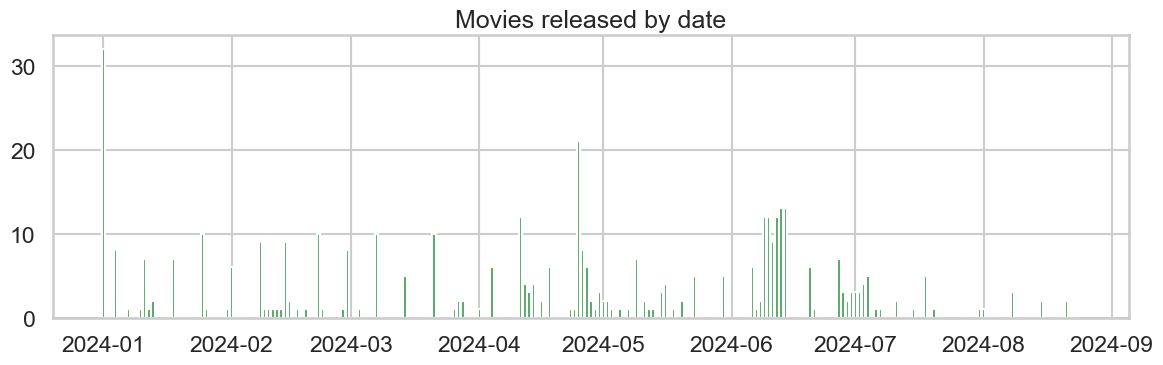

In [17]:
# Count releases by date and reindex to full range
rel_ts = (
    df_releases.groupby('ESTRENO').size().reset_index(name='num_movies')
)
full_range = pd.date_range(start=df_transactions['FECHA_FUNCION'].min(), end=df_transactions['FECHA_FUNCION'].max())
rel_ts = rel_ts.set_index('ESTRENO').reindex(full_range).reset_index().rename(columns={'index': 'ESTRENO'})
rel_ts['num_movies'] = rel_ts['num_movies'].fillna(0).astype(int)

print(rel_ts.shape)
print('Total movies released:', rel_ts['num_movies'].sum())

plt.figure(figsize=(12, 4))
plt.bar(rel_ts['ESTRENO'], rel_ts['num_movies'], width=0.8, color='C2')
plt.title('Movies released by date')
plt.tight_layout()

### Releases pace: insights
- Releases come in pulses; these days are natural anchors for communications.
- Aligning email cadence with release waves may improve relevance (to be tested).

---
### 2.4.3 Movies: On-Air Windows and Blockbuster Score

We approximate a title's on-air window and build a daily count and mix proxy (log2 sales) over time.

(246, 9)


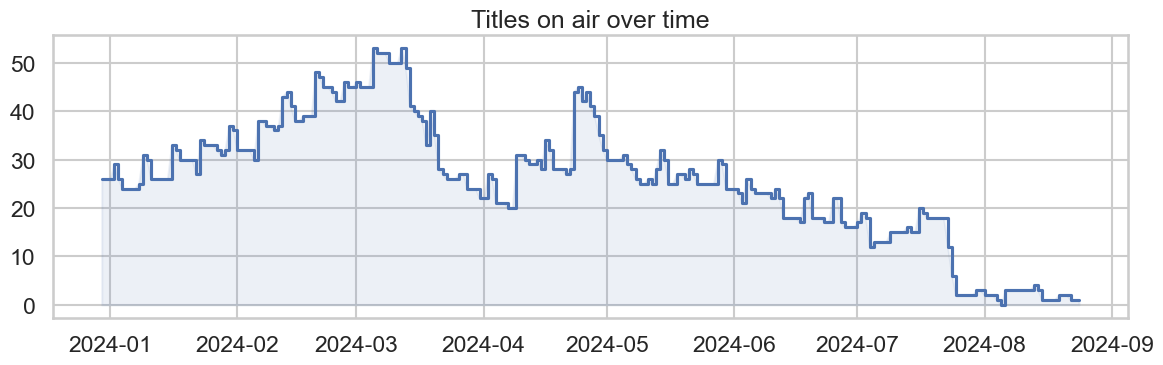

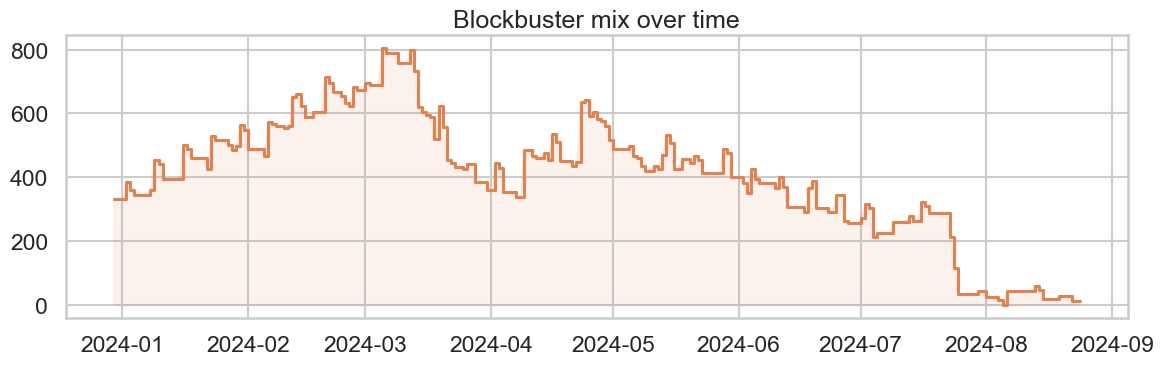

In [18]:
# Compute on-air windows per title from transactions and releases
rel_range = (
    df_transactions.groupby('TX_PELICULA_UNICA', as_index=False)
    .agg(
        date_end=('FECHA_FUNCION', 'max'),
        tickets_sold=('BOLETOS', 'sum'),
        money_sold=('IMPORTE_TAQUILLA', 'sum')
    )
    .merge(df_releases, how='inner', on='TX_PELICULA_UNICA')
    .assign(
        days_on_air=lambda x: (x['date_end'] - x['ESTRENO']).dt.days,
        blockbuster_score=lambda x: np.log2(x['VENTAS']),
        date_before_release=lambda x: x['ESTRENO'] - pd.Timedelta(days=2)
    )
)

print(rel_range.shape)

# Daily series: count titles on air and sum blockbuster score
date_range = pd.date_range(start=rel_range['date_before_release'].min(), end=rel_range['date_end'].max())
movies_on_air = (
    pd.DataFrame({'date': date_range})
    .assign(
        on_air=lambda df: df['date'].apply(lambda d: rel_range.query('date_before_release <= @d and date_end >= @d').shape[0]),
        blockbuster_mix=lambda df: df['date'].apply(lambda d: rel_range.query('date_before_release <= @d and date_end >= @d')['blockbuster_score'].sum()),
    )
)

plt.figure(figsize=(12, 4))
plt.step(movies_on_air['date'], movies_on_air['on_air'], where='post', label='Titles on air', color='C0')
plt.fill_between(movies_on_air['date'], movies_on_air['on_air'], color='C0', alpha=0.1)
plt.title('Titles on air over time')
plt.tight_layout()

plt.figure(figsize=(12, 4))
plt.step(movies_on_air['date'], movies_on_air['blockbuster_mix'], where='post', label='Blockbuster mix (log2 sales)', color='C1')
plt.fill_between(movies_on_air['date'], movies_on_air['blockbuster_mix'], color='C1', alpha=0.1)
plt.title('Blockbuster mix over time')
plt.tight_layout()

### Movies on-air: insights
- Higher counts of on-air titles and stronger blockbuster mix coincide with higher demand periods at the beginning, however for july and august, the blockbuster score and the number of tickets sold are not aligned, suggesting that data is ill.

---
### 2.4.4 Movies: Day-of-Week Release Pattern

We examine which weekdays are most common for releases.

         dow  size       pct
1     Monday    55  0.133820
5    Tuesday    21  0.051095
6  Wednesday    39  0.094891
4   Thursday   212  0.515815
0     Friday    35  0.085158
2   Saturday    22  0.053528
3     Sunday    27  0.065693


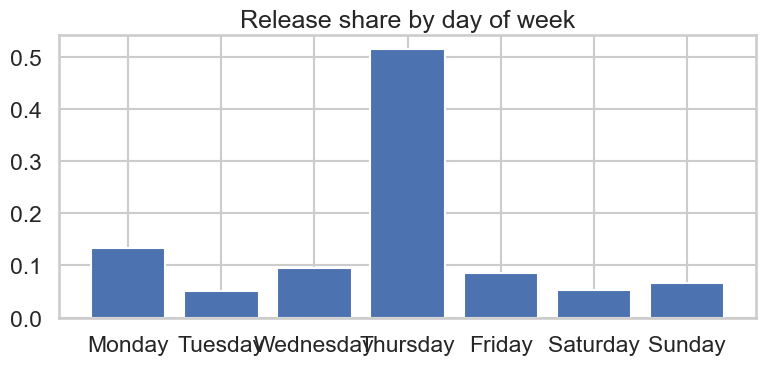

In [19]:
dow_rel = (
    df_releases
    .assign(dow=lambda x: x['ESTRENO'].dt.day_name())
    .groupby('dow', as_index=False)
    .size()
)
# Order weekday
dow_rel['dow'] = pd.Categorical(dow_rel['dow'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], ordered=True)
dow_rel = dow_rel.sort_values('dow').assign(pct=lambda x: x['size'] / x['size'].sum())
print(dow_rel)

plt.figure(figsize=(8, 4))
plt.bar(dow_rel['dow'].astype(str), dow_rel['pct'], color='C0')
plt.title('Release share by day of week')
plt.tight_layout()

### Release DOW: insights
- More than hald of movies are released on Thursday; however is not unique to this day.

---
### 2.4.5 Tickets: Child Ticket Heuristic

We flag transactions likely containing child tickets based on unit price vs regular price benchmark, this to see if customers have children in their party.

In [20]:
# Merge pricebook to get reference price per cinema
_df = df_transactions.merge(df_pricebook, how='left', on='ID_CINE')

# Heuristic: if unit price < regular price, infer presence of children/discounts
_df = _df.assign(
    unit_price=lambda x: x['IMPORTE_TAQUILLA'] / x['BOLETOS'],
    had_children=lambda x: np.where(x['unit_price'].lt(x['PRECIO_POL_R']), 1, 0)
)

print('Transactions with child/discount signal:', _df['had_children'].sum())
print('Share of transactions with signal:', _df['had_children'].mean())

# Persist back
df_transactions = _df

df_transactions.head()

Transactions with child/discount signal: 220019
Share of transactions with signal: 0.6841386815920398


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,unit_price,had_children
0,2ed9514e-4598-5a3a-b7eb-d3b71a312a07,903,2024-01-01,2024-01-01,246dcfe746f73242e3dc0ee6e1dff6ff169aae464c7af6...,7,AQUAMAN Y EL REINO PERDIDO,10,600.0,53.0,60.0,0
1,d8d32bdc-16d9-564c-a8ee-87125e669e33,355,2024-01-01,2024-01-01,d6de2ddad687c1471b307825bbaf6a5b54ca4ff8dfaab8...,1,EL NIÑO Y LA GARZA,5,450.0,77.0,90.0,0
2,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0,83.0,70.0,1
3,668f2c6a-af11-5552-a7e7-67d33ea470d3,273,2024-01-01,2024-01-01,f180d6ee7ed2986afc41d421ed36e84ca38fd437fb3a22...,1,¡PATOS!,2,82.0,75.0,41.0,1
4,b55a6b51-30ad-51dd-9317-58a2bcc5e9e4,905,2024-01-01,2024-01-01,b21d81b41698f87bf8a79ebe3bf52481f728d6b2542541...,5,PRISCILLA,2,370.0,166.0,185.0,0


### Child ticket heuristic: insights
- The heuristic is directional; discounts and promos can trigger false positives.
- Still useful as a coarse family signal for cinema-level segmentation.

---
### 2.4.6 Cinemas: Aggregate Statistics

We summarize performance per cinema and inspect distributions and child mix variation.

(103, 6)


,ID_CINE,total_tickets,total_transactions,total_spent,had_children,pct_children
3,60,20591,10189,1312953.0,7623,0.748160
42,344,19423,9553,1296460.3,5942,0.622004
9,166,17824,9061,1089548.7,7061,0.779274
23,234,17065,8729,1050401.7,6434,0.737083
8,154,17045,8319,988814.0,6432,0.773170


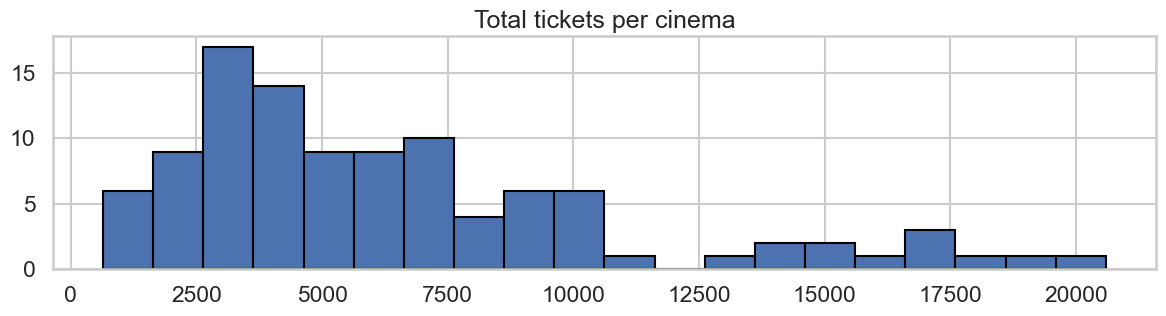

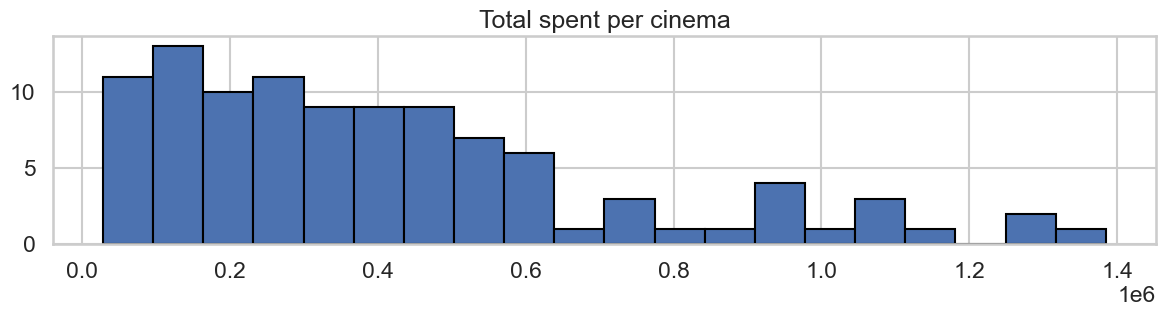

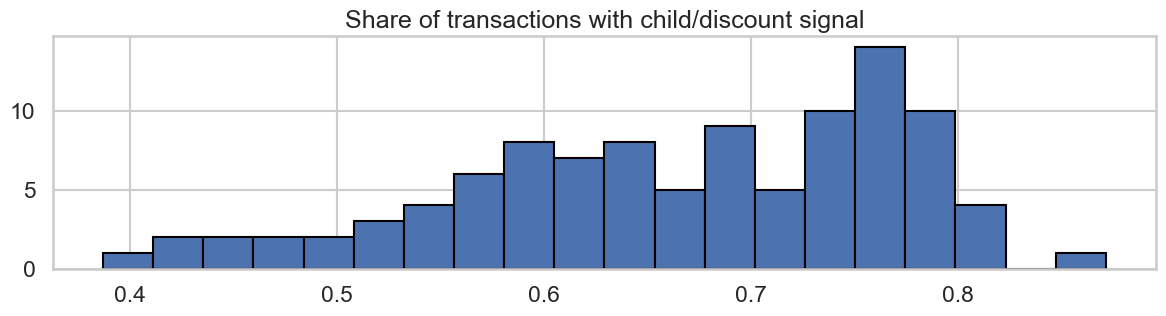

In [21]:
# Cinema-level stats
df_cinema_stats = (
    df_transactions
    .groupby('ID_CINE', as_index=False)
    .agg(
        total_tickets=('BOLETOS', 'sum'),
        total_transactions=('transaction_id', 'nunique'),
        total_spent=('IMPORTE_TAQUILLA', 'sum'),
        had_children=('had_children', 'sum')
    )
    .assign(pct_children=lambda x: np.where(x['total_transactions']>0, x['had_children']/x['total_transactions'], np.nan))
    .sort_values(by='total_tickets', ascending=False)
)
print(df_cinema_stats.shape)

# Distributions
plt.figure(figsize=(12, 3.5))
plt.hist(df_cinema_stats['total_tickets'], bins=20, color='C0', edgecolor='black')
plt.title('Total tickets per cinema')
plt.tight_layout()

plt.figure(figsize=(12, 3.5))
plt.hist(df_cinema_stats['total_spent'], bins=20, color='C0', edgecolor='black')
plt.title('Total spent per cinema')
plt.tight_layout()

plt.figure(figsize=(12, 3.5))
plt.hist(df_cinema_stats['pct_children'].dropna(), bins=20, color='C0', edgecolor='black')
plt.title('Share of transactions with child/discount signal')
plt.tight_layout()

df_cinema_stats.head()

### Cinemas: insights
- Strong skew across cinemas; a minority of locations carry a large share of volume (Pareto-like).
- Child/discount mix varies by cinema, suggesting local demographics and pricing differences.

---
### 2.4.7 Timing: Lead Time from Purchase to Show

We measure days between transaction date and show date to gauge advance purchase behavior.

count    321600.000000
mean          0.656651
std           3.622337
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          61.000000
Name: time_diff, dtype: float64
Share of same-day purchases: 0.8883737562189055


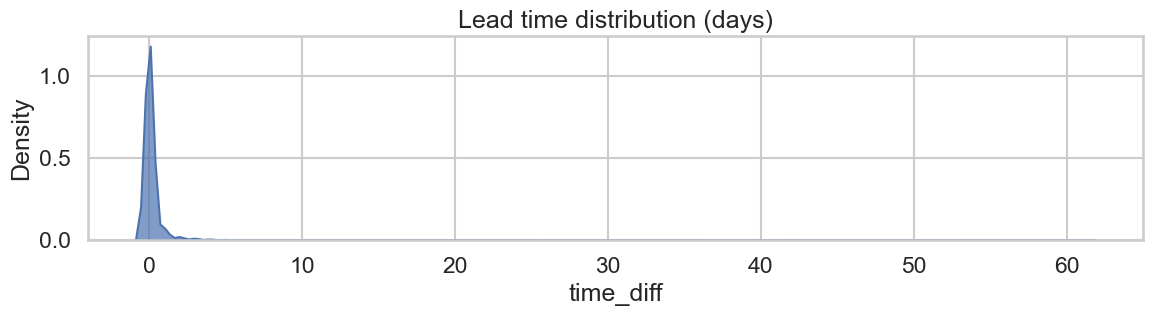

In [22]:
# Lead time (days) between purchase and show
df_transactions['time_diff'] = (df_transactions['FECHA_FUNCION'] - df_transactions['FECHA_TRANSACCION']).dt.days
print(df_transactions['time_diff'].describe())

plt.figure(figsize=(12, 3.5))
sns.kdeplot(df_transactions['time_diff'].dropna(), fill=True, color='C0', alpha=0.7)
plt.title('Lead time distribution (days)')
plt.tight_layout()

print('Share of same-day purchases:', df_transactions['time_diff'].eq(0).mean())

### Lead time: insights
- A sizable share of purchases occur on the same day; the rest show short advance windows.
- Implication on analysis: emails should action the same-day or at most in the next 7 days if effective.

---
### 2.4.8 Users: Cohort-Level Purchase Patterns

We summarize how many customers we see with transactions and emails, average activity per customer, and one-timer share.

In [23]:
# User-level KPIs
print('Clients with transactions:', df_transactions['CARD_MEMBERSHIPID'].nunique())
print('Clients with emails (merged scope):', df_emails['CARD_MEMBERSHIPID'].nunique())

# Reuse cust_join from earlier section
print('Clients with emails and trx:', (cust_join['num_emails']>0).sum())
print('Avg trx per client:', cust_join['total_transactions'].mean())
print('Avg tickets per client:', cust_join['total_tickets'].mean())
print('Share one-time buyers:', cust_join['total_transactions'].eq(1).mean())
print('Percentage of clients with only 1 email received:', cust_join.query('num_emails.gt(0)')['num_emails'].le(1).mean())

Clients with transactions: 264155
Clients with emails (merged scope): 326018
Clients with emails and trx: 15987
Avg trx per client: 1.217467017470803
Avg tickets per client: 2.5266226268668017
Share one-time buyers: 0.8409078003444947
Percentage of clients with only 1 email received: 0.9607180834427973


### Users: insights
- There are majority of the customers thatr transacted, only went once, having an implication on how to measure the impact of the campaigns, because we don't have a control group of users that never received emails.
- As well, from the customers that received emails, only 4% of them received more than 1 email, suggesting the treatment don't spill over to the next email. Making an RDD design more feasible to acccount for the impact of the campaigns.

---
## 2.5. Key Findings & Next Steps

### Data Landscape & Limitations
- Fragmented timelines: While emails are available since 2019, transactions and movie releases are only from 2024. This limits our ability to observe long-term customer behavior and true "never-emailed" controls.
- Customer ambiguity: We have 5.7M users, but lack clear join dates or full transaction histories. Many customers may have transacted before our window or outside the available data.
- No clean control group: Nearly all active customers have received at least one email, making it impossible to compare "never-emailed" vs. "emailed" groups without bias.

### Behavioral Patterns
- Strong seasonality: Demand is highly cyclical—weekends and holidays drive peaks, while Wednesdays are consistently low. Movie releases and blockbuster mix do not always align with these peaks, suggesting other factors at play.
- Transactional immediacy: 88% of transactions are for same-day showings, and most customers (84%) only transact once in the observed period. This means most purchase decisions are made quickly, leaving little room for long-term campaign effects.
- Email cadence is noisy: Campaigns often overlap, with multiple emails sent on the same day and little evidence of coordinated timing with movie releases or demand peaks.

### Email Impact: Observational Insights
- Low conversion rates: Same-day conversions after email sends are rare. When we look at a ±7-day window, the probability of purchase before and after an email is similar—no clear uplift is visible in raw comparisons.
- Confounded comparisons: Customers who receive emails differ systematically from those who do not, and with only 4% receiving more than one email, spillover effects are minimal. This makes simple group comparisons unreliable.

### RDD to measure impact of emails (Regression Discontinuity Design)
Given these realities:
- No true control group: We cannot find a large group of customers who never received emails.
- Treatment timing is sharp: The exact moment an email is sent is well-defined for each customer.
- Behavior is immediate: Most purchases happen within a few days of email receipt, so short windows around the send date capture most of the potential effect.
- Each customer as their own control: By comparing behavior just before and just after the email, we minimize confounding from unobserved differences between customers.

**RDD leverages the timing of the email as a "cutoff":**
- We compare the probability of purchase in the 7 days before vs. 7 days after the email for each customer.
- This design treats the email as an exogenous shock, using the customer’s own behavior as a baseline.
- It is robust to the lack of a never-emailed group and fits the data’s structure and business context.

**Summary:**
Given the data’s structure—no clean controls, immediate purchase behavior, and sharp treatment timing—an RDD quasi-experiment is the most credible approach to estimate the causal impact of email campaigns on cinema visits.


---
# 3. Re-create Data

We load transactions, pricebook, customers, emails, and releases. Dates are parsed and basic integrity filters are applied.

Insights (summary):
- We keep only valid transactions with positive tickets and revenue.
- Email timestamps are normalized to date granularity for daily paneling.
- Releases are filtered to those with positive sales.

In [24]:
# Read raw data CSVs from the repo data/ folder
# Note: paths are relative to this notebook location (src/)
df_transactions = pd.read_csv("../data/Transactions.csv", header=0)
df_pricebook = pd.read_csv("../data/Pricebook.csv", header=0)
df_customers = pd.read_csv("../data/Customers.csv", header=0)
df_emails = pd.read_csv("../data/Emails.csv", header=0)
df_releases = pd.read_csv("../data/Releases.csv", header=0, sep="|")

print("Shapes:")
print("Transactions:", df_transactions.shape)
print("Pricebook:", df_pricebook.shape)
print("Customers:", df_customers.shape)
print("Emails:", df_emails.shape)
print("Releases:", df_releases.shape)

Shapes:
Transactions: (329580, 8)
Pricebook: (103, 2)
Customers: (5718369, 2)
Emails: (1864512, 3)
Releases: (412, 3)


In [25]:
# Transactions wrangling
# - Create a transaction_id per (member, transaction date, show date)
# - Keep only positive tickets and revenue
# - Aggregate duplicates per ID; parse dates

df_transactions['transaction_id'] = df_transactions.apply(
    lambda x: str(uuid.uuid5(uuid.NAMESPACE_DNS, f"{x['CARD_MEMBERSHIPID']}_{x['FECHA_TRANSACCION']}_{x['FECHA_FUNCION']}")),
    axis=1
)

# Filter for valid sales
df_transactions = df_transactions.query('BOLETOS > 0').reset_index(drop=True)
df_transactions = df_transactions.query('IMPORTE_TAQUILLA > 0').reset_index(drop=True)

# Aggregate per transaction_id
cols_agg = {
    'ID_CINE': 'first',
    'FECHA_TRANSACCION': 'first',
    'FECHA_FUNCION': 'first',
    'CARD_MEMBERSHIPID': 'first',
    'ID_MARCA': 'first',
    'TX_PELICULA_UNICA': 'first',
    'BOLETOS': 'sum',
    'IMPORTE_TAQUILLA': 'sum'
}

df_transactions = (
    df_transactions
    .groupby('transaction_id', as_index=False)
    .agg(cols_agg)
    .assign(
        FECHA_TRANSACCION=lambda x: pd.to_datetime(x['FECHA_TRANSACCION'], format='%Y-%m-%d', errors='coerce'),
        FECHA_FUNCION=lambda x: pd.to_datetime(x['FECHA_FUNCION'], format='%Y-%m-%d', errors='coerce')
    )
    .sort_values('FECHA_TRANSACCION', ascending=True, ignore_index=True)
)

print("Transactions after cleaning:", df_transactions.shape)
df_transactions.head()

Transactions after cleaning: (304196, 9)


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA
0,9610a0e3-a813-5c2f-a25a-9ba3b3e033fa,234,2024-01-01,2024-01-01,49026ebf4714f93dcb5f9ae0230c4d4f9afb424d1c23da...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0
1,01984a03-5ec3-54e0-8696-d4622a181411,154,2024-01-01,2024-01-01,df624cc8bc0be3e8cb3de3522bf0f2728f6a88b5fe451e...,1,GODZILLA MINUS ONE,1,70.0
2,7b45b02a-a47b-506d-878a-79fde2bf8821,273,2024-01-01,2024-01-01,dc8f5462dfa0b2f78e04d6ae96f2bb597a7725c24a0b4a...,1,AQUAMAN Y EL REINO PERDIDO,2,82.0
3,8e9b0dc9-56f3-57c7-991d-f588c9712b7c,260,2024-01-01,2024-01-01,60b3ba400a6d9671cfe62a7114e415eae0e1af4e1ce738...,1,WONKA,2,82.0
4,eabdde26-84fd-58fb-8cc0-9fe46a839e57,273,2024-01-01,2024-01-02,2a81492ebbbdf24a683736eddd436e9430d43101acbdf4...,1,AQUAMAN Y EL REINO PERDIDO,2,170.0


In [26]:
# Join emails with customers for a consistent subscriber set
# - Normalize timestamps to dates and extract hour for potential use

df_emails = (
    df_emails
    .merge(df_customers, how='inner', left_on="SubscriberKeyH", right_on="SubscriberKey")
    .drop(columns=["SubscriberKeyH", "SubscriberKey"])
    .reset_index(drop=True)
)

# Parse timestamp and derive date and hour
df_emails['EventDate_TZ'] = pd.to_datetime(df_emails['EventDate'], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')
df_emails['EventDate'] = df_emails['EventDate_TZ'].dt.date

df_emails['EventDate_Hour'] = df_emails['EventDate_TZ'].dt.hour

print("Emails post-merge:", df_emails.shape)

df_releases['ESTRENO'] = pd.to_datetime(df_releases['ESTRENO'], format='%Y-%m-%d', errors='coerce')
df_releases = df_releases.query('VENTAS > 0').reset_index(drop=True)

print("Releases after basic cleaning:", df_releases.shape)

Emails post-merge: (478492, 5)
Releases after basic cleaning: (411, 3)


In [27]:
# Build a holiday calendar for Mexico over the transactions coverage
start_date = df_transactions['FECHA_TRANSACCION'].min()
end_date = df_transactions['FECHA_TRANSACCION'].max()
date_range = pd.date_range(start=start_date, end=end_date)
mx_holidays = holidays.MX(years=date_range.year.unique())

holiday_dates = [d for d in date_range if d in mx_holidays]
holiday_names = [mx_holidays[d] for d in holiday_dates]
df_mx_holidays = pd.DataFrame({'date': holiday_dates, 'holiday': holiday_names})

df_mx_holidays.head()

,date,holiday
0,2024-01-01,Año Nuevo
1,2024-02-05,Día de la Constitución
2,2024-03-18,Natalicio de Benito Juárez
3,2024-05-01,Día del Trabajo


In [28]:
# Compute per-movie windows and a blockbuster intensity index over time
# - For each movie: from 2 days before release to last show in transactions
# - Blockbuster score: log2 of sales (VENTAS); also a smoothed time series

df_releases_range = (
    df_transactions
    .groupby('TX_PELICULA_UNICA', as_index=False)
    .agg(
        date_end=('FECHA_FUNCION', 'max'),
        tickets_sold=('BOLETOS', 'sum'),
        money_sold=('IMPORTE_TAQUILLA', 'sum'),
    )
    .merge(df_releases, how='inner', on='TX_PELICULA_UNICA')
    .assign(
        days_on_air=lambda x: (x['date_end'] - x['ESTRENO']).dt.days,
        blockbuster_score=lambda x: np.log2(x['VENTAS']),
        date_before_release=lambda x: x['ESTRENO'] - pd.Timedelta(days=2),
    )
)

# Build daily series of concurrent movies and total blockbuster score
date_range = pd.date_range(start=df_releases_range['date_before_release'].min(),
                           end=df_releases_range['date_end'].max())

ts_movies_on_air = (
    pd.DataFrame({'date': date_range})
    .assign(
        on_air=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)').shape[0]
        ),
        blockbuster_score=lambda x: x['date'].apply(
            lambda d: df_releases_range.query('date_before_release.le(@d) and date_end.ge(@d)')['blockbuster_score'].sum()
        )
    )
)

# look
ts_movies_on_air.head()

,date,on_air,blockbuster_score
0,2023-12-30,26,330.612049
1,2023-12-31,26,330.612049
2,2024-01-01,26,330.612049
3,2024-01-02,29,383.376326
4,2024-01-03,26,360.557990


In [29]:
# Infer child presence from ticket unit price vs. reference price
# - Join pricebook by cinema; if unit price < reference, mark as child ticket
# - Build per-customer flags and aggregates (has_children)

df_transactions = df_transactions.merge(df_pricebook, how='left', on='ID_CINE')

df_transactions = (
    df_transactions
    .assign(
        had_children_ticket=lambda x: np.where(
            (x['IMPORTE_TAQUILLA'] / x['BOLETOS']).lt(x['PRECIO_POL_R']), 1, 0
        ),
        has_children=lambda x: x.groupby('CARD_MEMBERSHIPID')['had_children_ticket'].transform(lambda y: y.any().astype(int))
    )
)

print("Child-ticket transactions:", int(df_transactions['had_children_ticket'].sum()))
print("% child-ticket transactions:", df_transactions['had_children_ticket'].mean() * 100)

# Build time-series aggregates per customer (visits, spend)
df_transactions = (
    df_transactions
    .sort_values(by=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION'], ignore_index=True)
    .assign(
        cum_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['transaction_id'].cumcount() + 1,
        cum_spend=lambda x: x.groupby('CARD_MEMBERSHIPID')['IMPORTE_TAQUILLA'].cumsum(),
        avg_spend_per_visit=lambda x: x.groupby('CARD_MEMBERSHIPID')['IMPORTE_TAQUILLA'].transform('mean'),
        total_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['transaction_id'].transform('count'),
    )
    .sort_values(['total_visits', 'CARD_MEMBERSHIPID', 'FECHA_TRANSACCION'], ascending=[False, True, True], ignore_index=True)
)

# Favorite cinema per customer (mode of historical visits)
df_transactions['favorite_cinema'] = (
    df_transactions
    .groupby('CARD_MEMBERSHIPID')['ID_CINE']
    .transform(lambda x: x.mode()[0] if not x.mode().empty else None)
)

df_transactions.head()

Child-ticket transactions: 202846
% child-ticket transactions: 66.68266512380175


,transaction_id,ID_CINE,FECHA_TRANSACCION,FECHA_FUNCION,CARD_MEMBERSHIPID,ID_MARCA,TX_PELICULA_UNICA,BOLETOS,IMPORTE_TAQUILLA,PRECIO_POL_R,had_children_ticket,has_children,cum_visits,cum_spend,avg_spend_per_visit,total_visits,favorite_cinema
0,97315cc5-bb5e-58e1-a101-8a06cea3bb2e,334,2024-01-08,2024-01-08,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,WONKA,8,300.0,67.0,1,1,1,300.0,264.105263,19,334
1,ca50d66b-10ae-522b-828c-997b0d19d80b,334,2024-02-04,2024-02-04,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,ARGYLLE: AGENTE SECRETO,9,510.0,67.0,1,1,2,810.0,264.105263,19,334
2,e1834005-bb5f-59de-80dd-835c72769d17,334,2024-02-14,2024-02-14,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,HÉROE POR ENCARGO,2,106.0,67.0,1,1,3,916.0,264.105263,19,334
3,ccf15526-4e4e-5327-918f-887a4eb63eee,334,2024-03-20,2024-03-20,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,KUNG FU PANDA 4,2,140.0,67.0,0,1,4,1056.0,264.105263,19,334
4,9f29859d-2180-5140-b28e-844523812eca,334,2024-03-29,2024-03-29,ec9c5965132442238296cf35284a8a8a699acbe87d2a96...,1,GODZILLA Y KONG:EL NUEVO IMPERIO,2,130.0,67.0,1,1,5,1186.0,264.105263,19,334


---
# 4. ADT Panel Construction (RDD-ready)

We build a daily panel around each email, +/- K days. This creates matched pre/post windows to estimate the email’s near-term effect.

### 4.1: Configure window and filter emails
- We subset emails to a recent time range and convert event dates to pandas datetime.
- The preview above shows the first rows (member, send, date) we will expand into a daily panel.

In [30]:
# Step 1: Configure window and filter emails
K = 7
print(f"Window size K: {K} days")

# Filter a recent email window and parse dates
_df = (
    df_emails
    .loc[lambda x: (x['EventDate'] >= pd.to_datetime('2024-01-01').date()) &
                  (x['EventDate'] <= pd.to_datetime('2024-07-15').date())]
    .assign(EventDate=lambda x: pd.to_datetime(x['EventDate'], format='%Y-%m-%d', errors='coerce'))
)
print("Emails in window:", _df.shape)

# Preview the filtered emails (first 5)
_df[['CARD_MEMBERSHIPID', 'SendId', 'EventDate']].head()

Window size K: 7 days
Emails in window: (338326, 5)


,CARD_MEMBERSHIPID,SendId,EventDate
2625,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-20
2626,bb336857a3ecfaa063733cc1a6659588015e19a1f39036...,1456917,2024-06-20
2627,43dbd170cdbc119bfabd01436235060becbd820b256119...,1456917,2024-06-20
2628,e5724adf488adb0176f24706286a08e418d96c8c083a40...,1456917,2024-06-20
2629,6cc6f215b167ad6e689592dd9344c721dd263fe3bc6c75...,1456917,2024-06-20


#### 4.2: Expand emails into daily windows
- For each email date, we create a list of dates from K days before to K days after.
- The preview above shows the list we will explode into one row per day.

In [31]:
# Step 2: Build +/-K day ranges per email
_df_ranges = _df.assign(
    dates_to_expand=lambda x: x['EventDate'].apply(lambda d: pd.date_range(d - pd.Timedelta(days=K), d + pd.Timedelta(days=K), freq='D'))
)
print("Ranges built:", _df_ranges.shape)

# Preview first few range lists
_df_ranges[['CARD_MEMBERSHIPID', 'SendId', 'EventDate', 'dates_to_expand']].head()

Ranges built: (338326, 6)


,CARD_MEMBERSHIPID,SendId,EventDate,dates_to_expand
2625,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-20,"DatetimeIndex(['2024-06-13', '2024-06-14', '20..."
2626,bb336857a3ecfaa063733cc1a6659588015e19a1f39036...,1456917,2024-06-20,"DatetimeIndex(['2024-06-13', '2024-06-14', '20..."
2627,43dbd170cdbc119bfabd01436235060becbd820b256119...,1456917,2024-06-20,"DatetimeIndex(['2024-06-13', '2024-06-14', '20..."
2628,e5724adf488adb0176f24706286a08e418d96c8c083a40...,1456917,2024-06-20,"DatetimeIndex(['2024-06-13', '2024-06-14', '20..."
2629,6cc6f215b167ad6e689592dd9344c721dd263fe3bc6c75...,1456917,2024-06-20,"DatetimeIndex(['2024-06-13', '2024-06-14', '20..."


#### 4.3: Explode to daily panel
- Exploding the date lists gives us a daily panel per email and customer.
- The head above shows how each email now maps to multiple dates.

In [32]:
# Step 3: Expand to one row per day per email
emails_daily = (
    _df_ranges
    .loc[:, ['CARD_MEMBERSHIPID', 'SendId', 'dates_to_expand']]
    .explode('dates_to_expand')
    .rename(columns={'dates_to_expand': 'EventDate'})
    .reset_index(drop=True)
)
print("Daily rows:", emails_daily.shape)

# Preview first daily rows
emails_daily.head()

Daily rows: (5074890, 3)


,CARD_MEMBERSHIPID,SendId,EventDate
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17


#### 4.4: Add relative day index
- We assign a relative day index centered at 0 on the send day; negative is pre, positive is post.
- The head above shows the panel now includes the relative position around each email.

In [33]:
# Step 4: Add relative index from email day and keep [-K, K]
emails_daily['days_from_email'] = emails_daily.groupby(['CARD_MEMBERSHIPID', 'SendId']).cumcount() - K
print("days_from_email min/max:", int(emails_daily['days_from_email'].min()), int(emails_daily['days_from_email'].max()))

emails_daily = emails_daily.query("days_from_email.between(-@K, @K)").reset_index(drop=True)
print("Daily panel after trimming:", emails_daily.shape)

# Preview daily panel with relative day
emails_daily.head()

days_from_email min/max: -7 22
Daily panel after trimming: (5073210, 4)


,CARD_MEMBERSHIPID,SendId,EventDate,days_from_email
0,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-13,-7
1,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-14,-6
2,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-15,-5
3,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-16,-4
4,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,1454285,2024-06-17,-3


#### 4.5: Add transactions to panel
- We add daily context features to help control for demand: blockbuster intensity, holidays, releases, and weekly/monthly cycles.
- The head above previews these columns alongside the date.

In [34]:
# Step 5: Enrich with context (blockbuster, calendar, holidays)
emails_daily_ctx = (
    emails_daily
    .merge(ts_movies_on_air[['date', 'blockbuster_score']], how='left', left_on='EventDate', right_on='date')
    .drop(columns=['date'])
    .assign(
        weekday=lambda x: x['EventDate'].dt.day_name(),
        monthday=lambda x: x['EventDate'].dt.day,
        is_holiday=lambda x: x['EventDate'].isin(df_mx_holidays['date']).astype(int),
        is_release_day=lambda x: x['EventDate'].isin(df_releases['ESTRENO']).astype(int),
        sin_weekday=lambda x: np.sin(2 * np.pi * x['EventDate'].dt.weekday / 7),
        cos_weekday=lambda x: np.cos(2 * np.pi * x['EventDate'].dt.weekday / 7),
        sin_monthday=lambda x: np.sin(2 * np.pi * x['EventDate'].dt.day / 30.4),
        cos_monthday=lambda x: np.cos(2 * np.pi * x['EventDate'].dt.day / 30.4)
    )
)
print("Daily panel with context:", emails_daily_ctx.shape)

# Preview context columns
emails_daily_ctx[['EventDate','blockbuster_score','is_holiday','is_release_day','sin_weekday','cos_weekday']].head()

Daily panel with context: (5073210, 13)


,EventDate,blockbuster_score,is_holiday,is_release_day,sin_weekday,cos_weekday
0,2024-06-13,306.612852,0,1,0.433884,-0.900969
1,2024-06-14,306.612852,0,1,-0.433884,-0.900969
2,2024-06-15,306.612852,0,0,-0.974928,-0.222521
3,2024-06-16,306.612852,0,0,-0.781831,0.623490
4,2024-06-17,291.931504,0,0,0.000000,1.000000


#### 4.6: Flag purchases
- We join daily rows to same-day transactions to flag whether a purchase occurred (has_bought).
- The head above shows purchase flags with select user features used later as controls.

In [35]:
# Step 6: Merge transactions to flag purchase
trx_day = df_transactions.loc[:, ['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION', 'has_children', 'total_visits', 'avg_spend_per_visit', 'favorite_cinema', 'transaction_id']]

emails_daily_ctx_trx = (
    emails_daily_ctx
    .merge(trx_day, how='left', left_on=['CARD_MEMBERSHIPID', 'EventDate'], right_on=['CARD_MEMBERSHIPID', 'FECHA_TRANSACCION'])
    .drop(columns=['FECHA_TRANSACCION'])
    .assign(has_bought=lambda x: np.where(x['transaction_id'].notna(), 1, 0))
)
print("Panel after trx merge:", emails_daily_ctx_trx.shape)
print("Has_bought rate (%):", round(emails_daily_ctx_trx['has_bought'].mean() * 100, 3))

# Preview purchase labels and key user features
emails_daily_ctx_trx[['EventDate','CARD_MEMBERSHIPID','has_bought','has_children','total_visits','favorite_cinema']].head()

Panel after trx merge: (5073210, 19)
Has_bought rate (%): 0.03


,EventDate,CARD_MEMBERSHIPID,has_bought,has_children,total_visits,favorite_cinema
0,2024-06-13,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,0,NaN,NaN,NaN
1,2024-06-14,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,0,NaN,NaN,NaN
2,2024-06-15,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,0,NaN,NaN,NaN
3,2024-06-16,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,0,NaN,NaN,NaN
4,2024-06-17,e1c662ace88069c29bc9aee5f4242ca5630f8be47c4563...,0,NaN,NaN,NaN


#### 4.7: Stabilize user attributes
- We forward/backward fill stable user attributes so each daily row has consistent values.
- The head above shows these stabilized features for inspection.

In [36]:
# Step 7: Stabilize user features across the window (ffill/bfill)
emails_daily_ctx_trx_fb = (
    emails_daily_ctx_trx
    .sort_values(by=['CARD_MEMBERSHIPID', 'EventDate'], ignore_index=True)
    .assign(
        has_children=lambda x: x.groupby('CARD_MEMBERSHIPID')['has_children'].ffill().bfill(),
        avg_spend_per_visit=lambda x: x.groupby('CARD_MEMBERSHIPID')['avg_spend_per_visit'].ffill().bfill(),
        favorite_cinema=lambda x: x.groupby('CARD_MEMBERSHIPID')['favorite_cinema'].ffill().bfill(),
        total_visits=lambda x: x.groupby('CARD_MEMBERSHIPID')['total_visits'].ffill().bfill()
    )
)
print("Panel after ffill/bfill:", emails_daily_ctx_trx_fb.shape)

# Preview stabilized features
emails_daily_ctx_trx_fb[['CARD_MEMBERSHIPID','EventDate','has_children','total_visits','avg_spend_per_visit','favorite_cinema']].head()

Panel after ffill/bfill: (5073210, 19)


,CARD_MEMBERSHIPID,EventDate,has_children,total_visits,avg_spend_per_visit,favorite_cinema
0,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,2023-12-28,1.0,3.0,45.833333,306.0
1,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,2023-12-29,1.0,3.0,45.833333,306.0
2,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,2023-12-30,1.0,3.0,45.833333,306.0
3,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,2023-12-31,1.0,3.0,45.833333,306.0
4,00004d2112d6ecc1589a0c8465488eb0d5aa53f26ded51...,2024-01-01,1.0,3.0,45.833333,306.0


#### 4.8: Final panel shape
- Built a balanced pre/post window (K=7 days) around each email.
- Enriched with calendar, holiday, release, and blockbuster context.
- Labeled daily purchase outcomes to enable both ML and RDD estimations.

In [37]:
# Step 8: Define RDD variables and finalize panel
panel_final = emails_daily_ctx_trx_fb.assign(
    is_post=lambda x: x['days_from_email'].gt(0).astype(int),
    r=lambda x: np.where(x['days_from_email'].gt(0), x['days_from_email'], 0),
    w=lambda x: 1 - x['days_from_email'].abs() / (K + 1),  # Triangular kernel weight
)

# Drop the exact email day (0) to avoid exposure mixing
panel_final = panel_final.query("days_from_email != 0").reset_index(drop=True)

print("Final panel shape:", panel_final.shape)
print("Post-period share (%):", round(panel_final['is_post'].mean() * 100, 3))
print("Purchase rate (%):", round(panel_final['has_bought'].mean() * 100, 3))

# Preview finalized panel
panel_final[['CARD_MEMBERSHIPID','EventDate','days_from_email','is_post','w','has_bought']].head()

# Keep downstream variable name
df_emails_expanded = panel_final.copy()

Final panel shape: (4734996, 22)
Post-period share (%): 50.0
Purchase rate (%): 0.031


---
# 5. ML Model: Purchase Prediction and Uplift Read

We train CatBoost to predict daily purchase probability in the panel and examine whether the post-email indicator is predictive after controlling for other drivers.

### 5.1: Define features/target and basic checks
We prepare X, y, and sample weights (triangular kernel). We also verify missing values and basic distributions.

In [38]:
# Select features and target for ML
cols2use = [
    'blockbuster_score',
    'is_holiday',
    'sin_weekday', 'cos_weekday',
    'sin_monthday', 'cos_monthday',
    'has_children', 'total_visits',
    'favorite_cinema', 'SendId',
    'is_post',  # treatment flag
]
cat_cols = ['is_post', 'is_holiday', 'has_children', 'favorite_cinema', 'SendId']

X = df_emails_expanded[cols2use].copy()
X['has_children'] = X['has_children'].fillna(-1).astype(int)
X['is_post'] = X['is_post'].astype(int)
X['is_holiday'] = X['is_holiday'].astype(int)
X['favorite_cinema'] = X['favorite_cinema'].fillna(-1).astype(int)
X['SendId'] = X['SendId'].astype(str)
X[cat_cols] = X[cat_cols].astype('category')

y = df_emails_expanded['has_bought'].copy()
w_weights = df_emails_expanded['w'].copy()  # triangular kernel weights

# Basic checks
print("X shape:", X.shape, " y shape:", y.shape)
print("NaNs per column:\n", X.isna().sum())
print("Class balance (bought=1) %:", round(y.mean()*100,3))

X shape: (4734996, 11)  y shape: (4734996,)
NaNs per column:
 blockbuster_score    19028
is_holiday               0
sin_weekday              0
cos_weekday              0
sin_monthday             0
cos_monthday             0
has_children             0
total_visits          2030
favorite_cinema          0
SendId                   0
is_post                  0
dtype: int64
Class balance (bought=1) %: 0.031


#### 5.2: Split, build pools, and train
- Split into train/validation, stratifying by treatment (is_post) for balance.
- Build CatBoost pools to handle categorical features and sample weights.
- Train with early stopping using the validation set.

In [39]:
# Step 2: Train/validation split (stratify by treatment)
X_train, X_val, y_train, y_val, w_train, w_val = train_test_split(
    X, y, w_weights, test_size=0.2, random_state=42, stratify=X['is_post']
)
print(f"Train size: {X_train.shape}, Val size: {X_val.shape}")

# Step 3: Build CatBoost pools
pool_train = Pool(X_train, y_train, weight=w_train, cat_features=cat_cols)
pool_val = Pool(X_val, y_val, weight=w_val, cat_features=cat_cols)

# Step 4: Train CatBoost
model = CatBoostClassifier(
    loss_function="Logloss",
    random_seed=42,
    verbose=100,
    learning_rate=0.1,
)
model.fit(pool_train, eval_set=pool_val, early_stopping_rounds=50)

Train size: (3787996, 11), Val size: (947000, 11)
0:	learn: 0.3690942	test: 0.3690935	best: 0.3690935 (0)	total: 459ms	remaining: 7m 38s
100:	learn: 0.0027864	test: 0.0027734	best: 0.0027733 (94)	total: 30s	remaining: 4m 26s
200:	learn: 0.0027275	test: 0.0027679	best: 0.0027666 (154)	total: 1m	remaining: 4m 1s
300:	learn: 0.0026866	test: 0.0027603	best: 0.0027601 (291)	total: 1m 34s	remaining: 3m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.002760128006
bestIteration = 291

Shrink model to first 292 iterations.


### 5.3: Evaluate and interpret
- Report precision/recall/F1 for both classes.
- Use SHAP to understand global importance and targeted relationships (including is_post).

/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ravj/miniforge3/envs/data_analysis/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

  Not Bought     0.9997    1.0000    0.9998    946710
      Bought     0.0000    0.0000    0.0000       290

    accuracy                         0.9997    947000
   macro avg     0.4998    0.5000    0.4999    947000
weighted avg     0.9994    0.9997    0.9995    947000



/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_57916/2888208372.py:10: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_val, plot_type="dot", max_display=20)


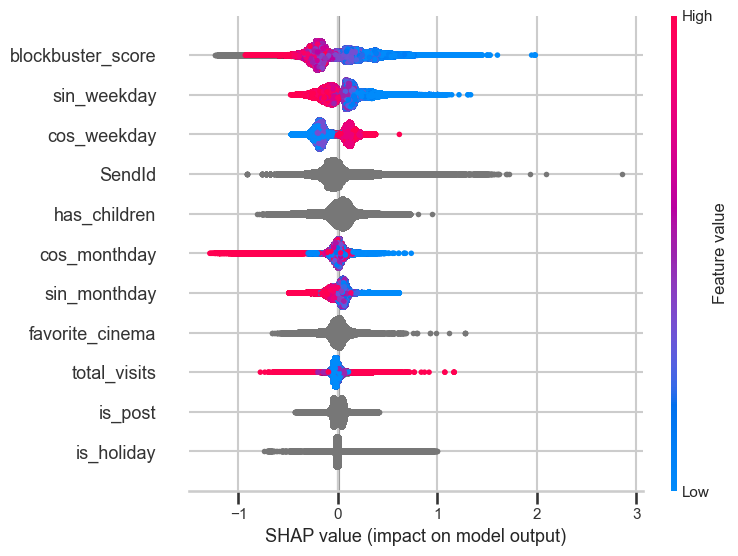

Top features by mean |SHAP|:
 blockbuster_score    0.235082
sin_weekday          0.161809
cos_weekday          0.154467
SendId               0.120396
has_children         0.097078
cos_monthday         0.076328
sin_monthday         0.070873
favorite_cinema      0.064231
total_visits         0.043406
is_post              0.043249
dtype: float64


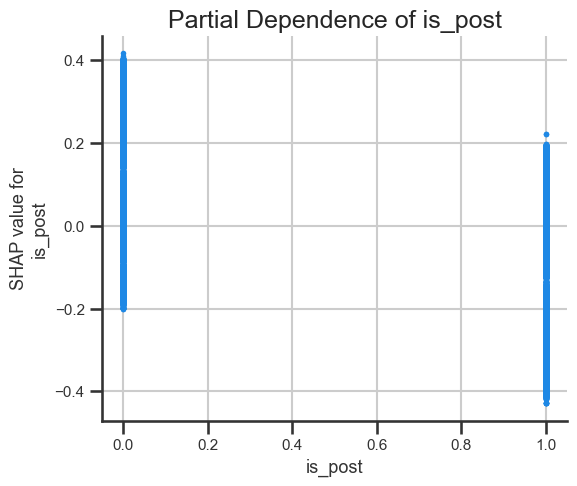

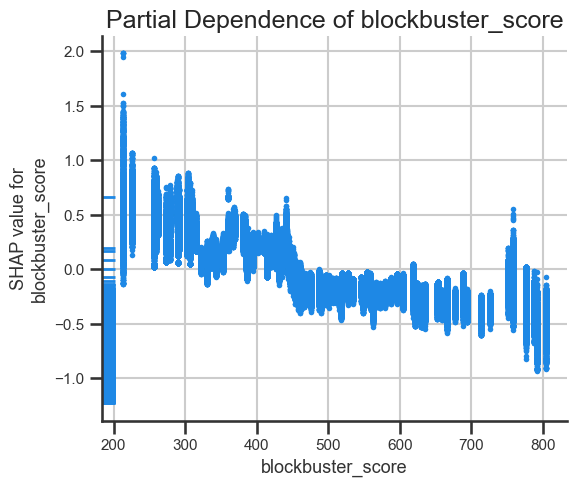

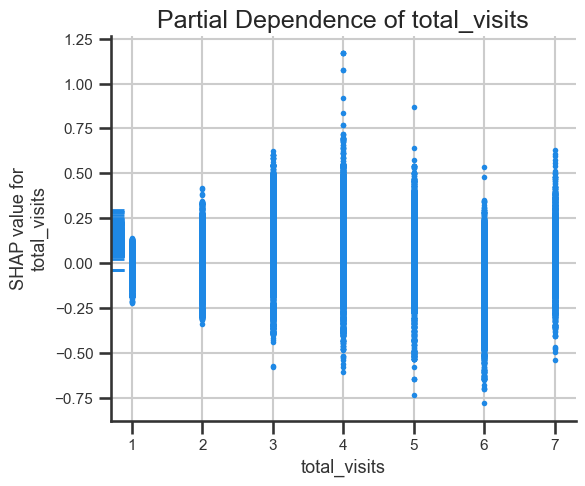

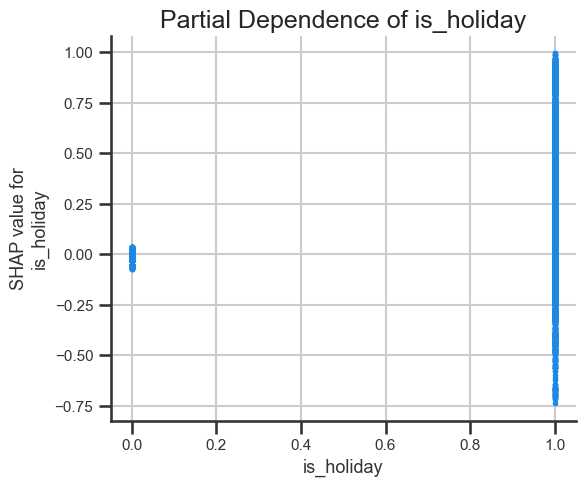

In [40]:
# Step 5: Evaluate classification metrics on validation set
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=['Not Bought', 'Bought'], digits=4))

# Step 6: SHAP interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val)

# Global importance summary
shap.summary_plot(shap_values, X_val, plot_type="dot", max_display=20)

# Top features by mean |SHAP|
shap_abs = np.abs(shap_values)
feat_importance = pd.Series(shap_abs.mean(axis=0), index=X_val.columns).sort_values(ascending=False)
print("Top features by mean |SHAP|:\n", feat_importance.head(10))

# Targeted partials (including treatment)
for feat in ['is_post', 'blockbuster_score', 'total_visits', 'is_holiday']:
    shap.dependence_plot(feat, shap_values, X_val, interaction_index=None, show=False)
    plt.title(f'Partial Dependence of {feat}')
    plt.show()

#### Insights: ML Model
- The model captures calendar effects and user history while assessing the post-email flag.
- Inspect SHAP for whether 'is_post' meaningfully shifts purchase probability after controlling for confounders.
- Use caution: model-based association is not causal, but it helps detect patterns that RDD might miss.

---
# 6. RDD: GLM with Cluster-Robust Errors

We estimate the post-email jump using a simple logistic GLM, clustering standard errors by customer to account for within-user correlation.

### 6.1: Fit Linear Model with robust SEs
We classify the day type and build a compact GLM formula with treatment and calendar controls.

In [41]:
# Step 1a: Day type categorical: weekend, Wednesday, other (baseline)
df_emails_expanded['type_of_day'] = np.where(
    df_emails_expanded['EventDate'].dt.weekday.isin([5, 6]), 'weekend',
    np.where(df_emails_expanded['EventDate'].dt.weekday == 2, 'wednesday', 'other')
)
print(df_emails_expanded['type_of_day'].value_counts(normalize=True).rename('%').mul(100).round(2))

# Step 1b: Simple RDD formula: treatment + calendar controls
formula = "has_bought ~ is_post + C(type_of_day, Treatment('other')) + is_holiday"
print("RDD formula:", formula)

# Step 2: Ensure no missing values in used fields
df_emails_expanded['has_children'] = df_emails_expanded['has_children'].fillna(0).astype(int)

# Step 3: Fit GLM Binomial with cluster-robust SE at customer level
rdd_model = smf.glm(formula, data=df_emails_expanded, family=sm.families.Binomial())
glm_res = rdd_model.fit(cov_type='cluster', cov_kwds={'groups': df_emails_expanded['CARD_MEMBERSHIPID']})

# Step 4: Report
tbl = glm_res.summary()
print("RD jump (is_post) on log-odds:", glm_res.params['is_post'])
print("RD jump (is_post) as odds ratio:", np.exp(glm_res.params['is_post']))

type_of_day
other        57.14
weekend      28.57
wednesday    14.29
Name: %, dtype: float64
RDD formula: has_bought ~ is_post + C(type_of_day, Treatment('other')) + is_holiday
RD jump (is_post) on log-odds: -0.05822333165105527
RD jump (is_post) as odds ratio: 0.943439224067494


In [42]:
# look table
print(tbl)

                 Generalized Linear Model Regression Results                  
Dep. Variable:             has_bought   No. Observations:              4734996
Model:                            GLM   Df Residuals:                  4734991
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13187.
Date:                Mon, 11 Aug 2025   Deviance:                       26375.
Time:                        18:11:09   Pearson chi2:                 4.74e+06
No. Iterations:                    12   Pseudo R-squ. (CS):          1.136e-05
Covariance Type:              cluster                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

## 6.2 Plot effects

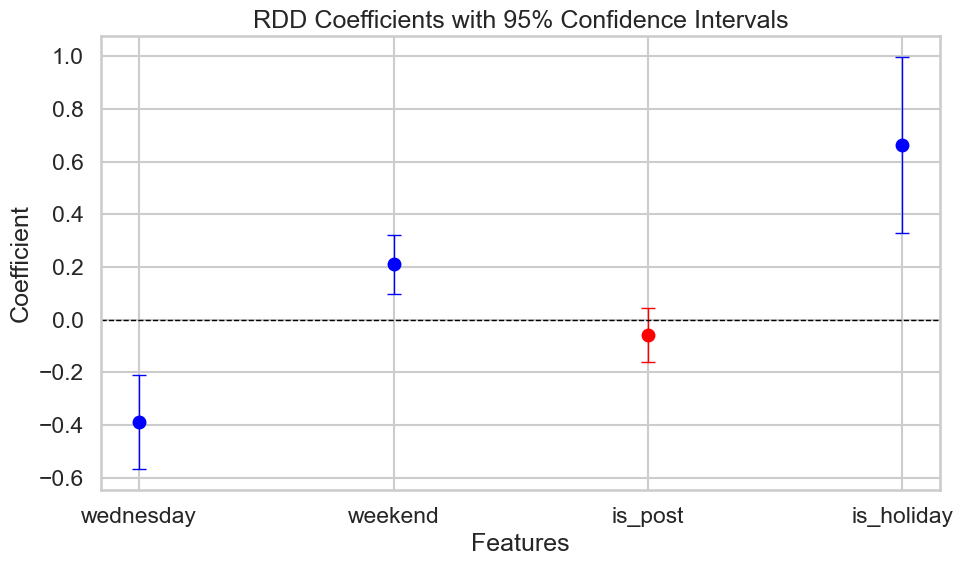

In [43]:
# Step 5: Plot coefficients with 95% CIs
coef_df = pd.DataFrame({
    'feature': glm_res.params.index,
    'coef': glm_res.params.values,
    'conf_int_lower': glm_res.conf_int()[0],
    'conf_int_upper': glm_res.conf_int()[1],
    'p_value': glm_res.pvalues.values
})
coef_df = coef_df[coef_df['feature'] != 'Intercept']
coef_df['feature'] = coef_df['feature'].str.replace(r"C\(type_of_day, Treatment\('other'\)\)\[T\.", '', regex=True)
coef_df['feature'] = coef_df['feature'].str.replace(r"\]", '', regex=True)
coef_df['color'] = np.where(coef_df['p_value'] < 0.05, 'blue', 'red')

plt.figure(figsize=(10, 6))
for _, row in coef_df.iterrows():
    plt.errorbar(
        row['feature'], row['coef'],
        yerr=[[row['coef'] - row['conf_int_lower']], [row['conf_int_upper'] - row['coef']]],
        fmt='o', color=row['color'], capsize=5, elinewidth=1, markeredgewidth=1
    )
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xticks(rotation=0)
plt.title('RDD Coefficients with 95% Confidence Intervals')
plt.xlabel('Features')
plt.ylabel('Coefficient')
plt.tight_layout()
plt.show()


In [44]:
# Step 6: Predictive sanity check
y_pred = glm_res.predict(df_emails_expanded)
print("Share predicted >0.5:", float((y_pred > 0.5).mean()))

Share predicted >0.5: 0.0


#### Insights: RDD GLM
- The coefficient on 'is_post' measures the discontinuity in purchase probability right after emails, controlling for day-type and holidays, with customer-clustered SEs.
- In this run, the estimate is small and statistically insignificant, indicating no clear uplift.
- Caveats: local design (+/- K days), daily aggregation, and potential unobserved confounding (e.g., time-of-day or concurrent promos).

---
# 99. Conclusion and Next Steps

Summary
- No statistically significant uplift detected in purchases immediately after emails in this specification.
- ML reveals calendar and user-history as dominant drivers; the post-email signal is weak once controls are applied.

Next steps
- Increase granularity: incorporate send hour and within-day purchase timing.
- Explore heterogeneous effects (e.g., by visit frequency, family presence, cinema region).
- Bayesian RDD to quantify uncertainty more fully.
- Design an RCT to establish causality and calibrate expected lift.
- Consider geo experiments (treated vs. control cities) to reduce spillovers.